# 8.tf.image.crop_to_bounding_box

With image and bounding box coordinate, crop the image using `tf.image.crop_to_bounding_box` function. 

Based on kaggle ['Humpback Whale Identification'](https://www.kaggle.com/c/humpback-whale-identification)

## Set up

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import load_model
from keras.preprocessing import image

Using TensorFlow backend.


## Load the csv file

Download csv file in https://www.kaggle.com/martinpiotte/bounding-box-model.

__coords__ mean 'w0', 'h0', 'w1', 'h1'

In [2]:
label_df = pd.read_csv('c:/Users/home/Downloads/coords-fixed.csv')

In [3]:
label_df.head()

,filename,coords
0,0000e88ab.jpg,"[160, 189, 433, 887]"
1,0001f9222.jpg,"[74, 4, 251, 752]"
2,00029d126.jpg,"[33, 33, 461, 1021]"
3,00050a15a.jpg,"[163, 26, 372, 1024]"
4,0005c1ef8.jpg,"[146, 11, 327, 1034]"


### Keras function
* `keras.image.img_load` output range is 0~255.

In [4]:
img = image.load_img('c:/Users/home/Downloads/humpback-whale-identification/train/0000e88ab.jpg')
img = image.img_to_array(img)

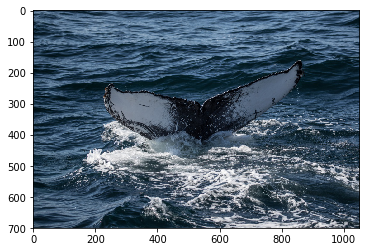

In [5]:
plt.imshow(img/255)

### Tensorflow function
* `tf.image` output range is 0~1.

In [ ]:
image_string = tf.read_file('c:/Users/home/Downloads/humpback-whale-identification/train/0000e88ab.jpg')
image = tf.image.decode_jpeg(image_string, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)

In [ ]:
plt.imshow(image)

When load the data using 'label_df.iterrows(), the 'coords' column output is '[33, 33, 461, 1021]'.

To use following method, I can read the coordination `iterrows()` with int type and use `tf.image.crop_to_bounding_box` to crop image.


`tf.image.crop_to_bounding_box` Args([document](https://www.tensorflow.org/api_docs/python/tf/image/crop_to_bounding_box)):
* image: 4-D Tensor of shape [batch, height, width, channels] or 3-D Tensor of shape [height, width, channels].
* offset_height: Vertical coordinate of the top-left corner of the result in the input.
* offset_width: Horizontal coordinate of the top-left corner of the result in the input.
* target_height: Height of the result.
* target_width: Width of the result.


First, I test the detail process.

In [27]:
label_df.coords.values[0]

'[160, 189, 433, 887]'

In [34]:
sample_a = label_df.coords[0]

In [35]:
idx = sample_a.replace(',', '').replace('[', '').replace(']', '').split()
idx = list(map(int, idx))

In [37]:
print(idx)

[160, 189, 433, 887]


Now apply the coords in image.

In [38]:
crop_img = tf.image.crop_to_bounding_box(img, idx[0], idx[1], (idx[2]-idx[0]), (idx[3]-idx[1]))

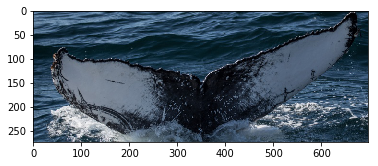

In [40]:
plt.imshow(crop_img/255)

## Apply `tf.data`

Before make `tf.data`, change 'coords' columns

### Load the train.csv 

In [134]:
train_df = pd.read_csv('c:/Users/home/Downloads/humpback-whale-identification/train.csv')

In [135]:
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


Add 'coords' columns in train_df

In [140]:
train_df['coords'] = label_df.coords[:25361]

Make 'coords' type to list

In [141]:
for i, j in label_df.iterrows():
    coords = j.coords.replace(',', '').replace('[', '').replace(']', '').split()
    coords = list(map(int, coords))
    train_df.coords[i] = coords
    if i == 25360: #label csv is about 30K rows, but train_df is about 25K.
        break

### Make `tf.data`

In [142]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.Image, train_df.Id, train_df.coords))

In [143]:
for i, j, k in train_data.take(1):
    print(i)
    print(j)
    print(k)

tf.Tensor(b'0000e88ab.jpg', shape=(), dtype=string)
tf.Tensor(b'w_f48451c', shape=(), dtype=string)
tf.Tensor([160 189 433 887], shape=(4,), dtype=int32)


### Define crop_img function

Make the crop_img function grouping above code.

To use `tf.data`, I use `tf.imgae` API.

In [144]:
def crop_img(img_file, coords):
    '''
    img_file : image file name and define path to your folder path
    coords : bounding box coordination, 'w0', 'h0', 'w1', 'h1'
    '''
    image_path = 'c:/Users/home/Downloads/humpback-whale-identification/train/' + img_file
    image_string = tf.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    crop_img = tf.image.crop_to_bounding_box(image, coords[0], coords[1], (coords[2]-coords[0]), (coords[3]-coords[1]))
    
    return crop_img

In [145]:
train_data = train_data.map(lambda x, y, z : (crop_img(x,  z), y, z))

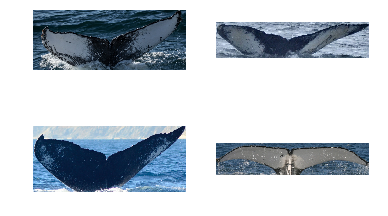

In [152]:
ax = 0
for i, j, k in train_data.take(4):
    plt.subplot(2,2, ax+1)
    plt.imshow(i)
    plt.axis('off')
    ax += 1

## Summary

1. Convert origin 'coords' columns type to list.
2. Load the image and apply `tf.image.crop_to_bounding_box` function. 